In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('train_dl.csv')
df2 = pd.read_csv('test_dl.csv')

In [4]:
df.shape

(10494, 2)

In [5]:
df = df.dropna()

In [6]:
df

,Body,Labels
0,2017.0 sakura clicker this ha helped me throug...,1
1,2017.0 crusader of the lost idol awesome idea ...,1
2,2014.0 raceroom racing experience this game is...,0
3,2018.0 black squad early access reviewhere wha...,1
4,2014.0 dc world steam edition very detailed si...,1
...,...,...
10489,2016.0 path of exile i have 360 hour in this g...,1
10490,2018.0 ring of elysium early access reviewpret...,1
10491,2016.0 bloons td battle started completed tuto...,0
10492,2016.0 thehunter classic a of the time of this...,1


In [7]:
df.isnull().sum()

Body      0
Labels    0
dtype: int64

In [9]:
! pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 6.5 MB 31.9 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Bidirectional Encoder Representations from Transformers (BERT) for Natural Language Processing
To put it in simple words BERT extracts patterns or representations from the data or word embeddings by passing it through an encoder. The encoder itself is a transformer architecture that is stacked together. It is a bidirectional transformer which means that during training it considers the context from both left and right of the vocabulary to extract patterns or representations. 
### The Transformers
BERT’s main component is the transformer architecture. The transformers are made up of two components: encoder and decoder. The encoder itself contains two components: the self-attention layer and feed-forward neural network. 

### Text Preprocessing
every input embedding is a combination of 3 embeddings:

Position Embeddings: BERT learns and uses positional embeddings to express the position of words in a sentence. These are added to overcome the limitation of Transformer which, unlike an RNN, is not able to capture “sequence” or “order” information
Segment Embeddings: BERT can also take sentence pairs as inputs for tasks (Question-Answering). That’s why it learns a unique embedding for the first and the second sentences to help the model distinguish between them. In the above example, all the tokens marked as EA belong to sentence A (and similarly for EB)
Token Embeddings: These are the embeddings learned for the specific token from the WordPiece token vocabulary

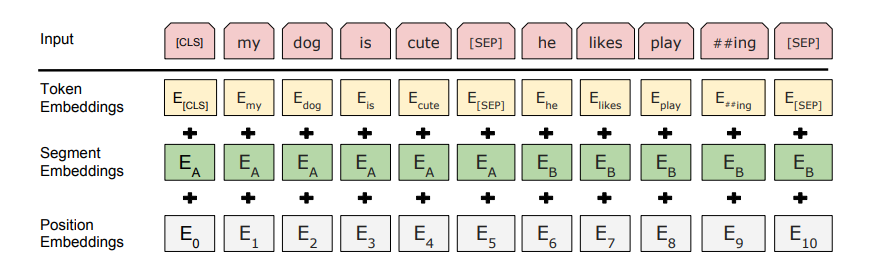
### The core of BERT is trained using two methods, next sentence prediction (NSP) and masked-language modeling (MLM).
1.Next Sentence Prediction consists of taking pairs of sentences as inputs to the model, some of these pairs will be true pairs, others will not.

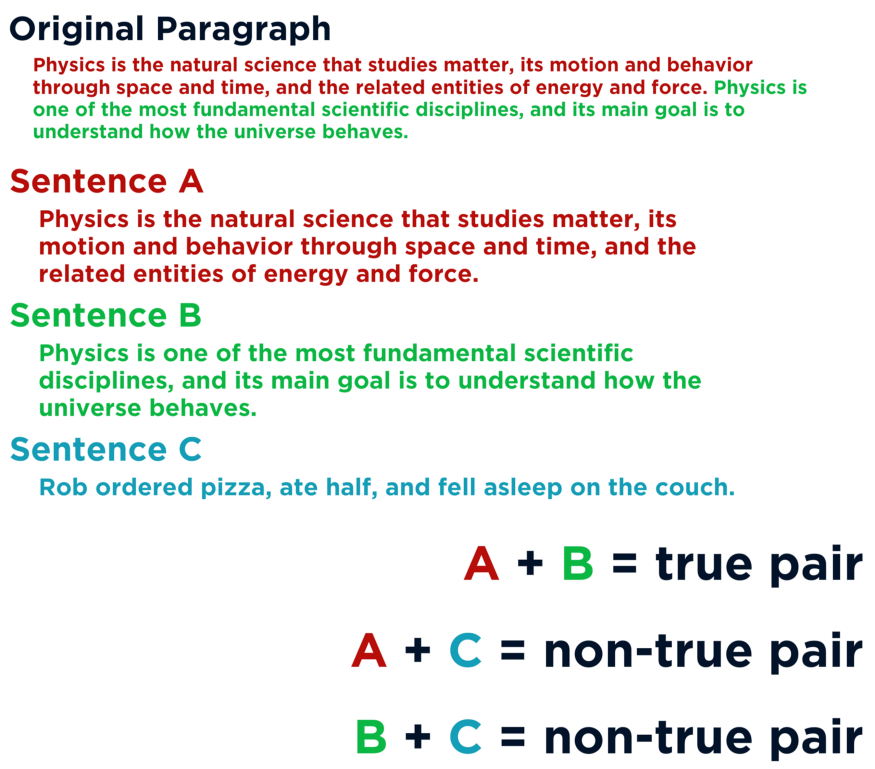
##### Two consecutive sentences result in a ‘true pair’, anything else is not a true pair.

2.Masked-Language Modeling consists of taking a chunk of text, masking a given number of tokens, and asking BERT to predict what the masked word is.

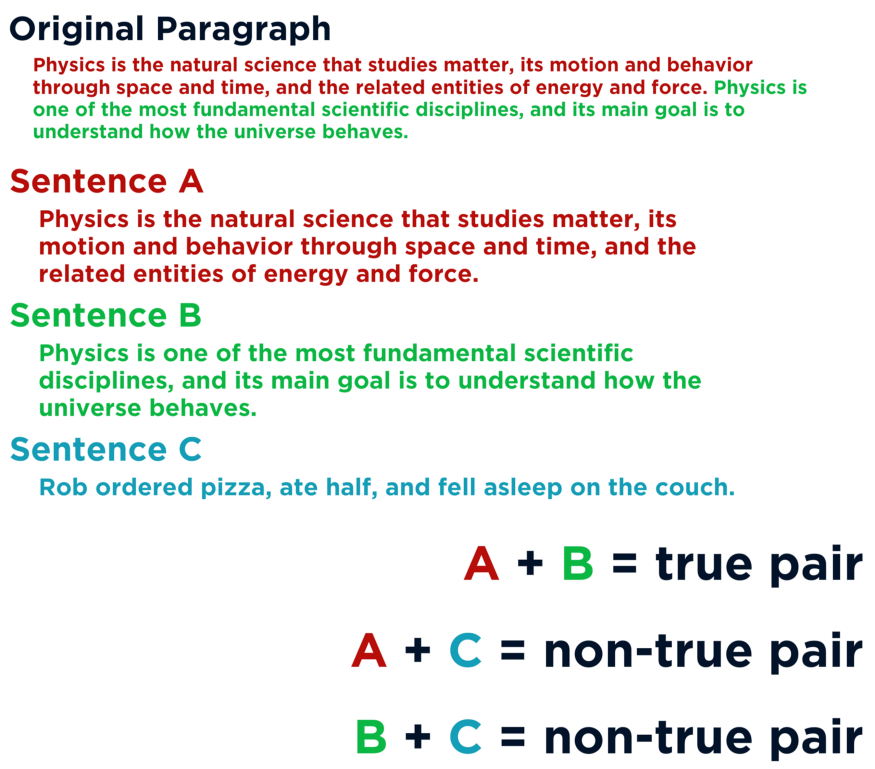
#### 15% of the words in each sequence are masked with the [MASK] token.

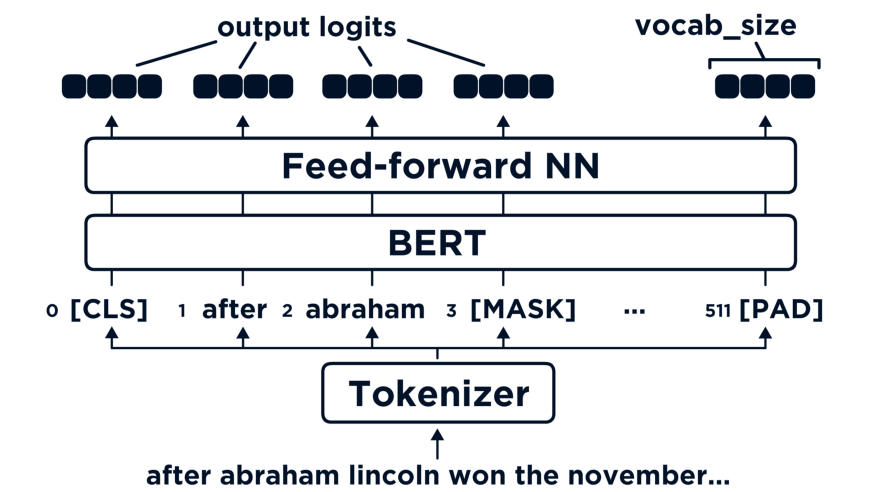

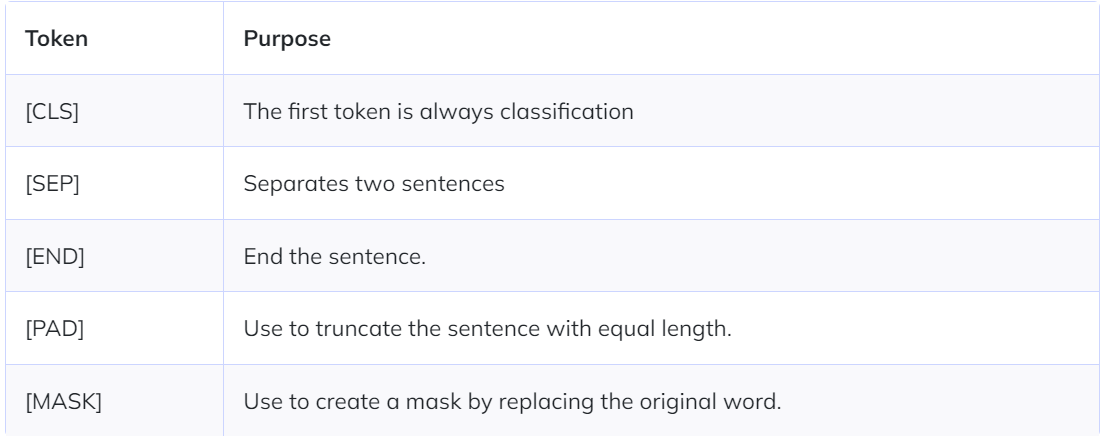
### ref: https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial

In [10]:
import torch
from tqdm.notebook import tqdm  # for progress bar 
# tqdm https://towardsdatascience.com/training-models-with-a-progress-a-bar-2b664de3e13e
# https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/
from transformers import BertTokenizer
# Each sample will be retrieved by indexing tensors along the first dimension.
# (TensorDataset) https://blog.csdn.net/qq_40211493/article/details/107529148?spm=1001.2101.3001.6650.5&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-5.pc_relevant_antiscanv2&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-5.pc_relevant_antiscanv2&utm_relevant_index=10
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

df.head()

,Body,Labels
0,2017.0 sakura clicker this ha helped me throug...,1
1,2017.0 crusader of the lost idol awesome idea ...,1
2,2014.0 raceroom racing experience this game is...,0
3,2018.0 black squad early access reviewhere wha...,1
4,2014.0 dc world steam edition very detailed si...,1


In [11]:
possible_labels = df.Labels.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 1, 1: 0}

In [12]:
#df['label'] = df.Labels.replace(label_dict)

df['label'] = df['Labels']
#df2['label'] = df2['Labels']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Labels', 'data_type']).count()

Body  label
Labels data_type             
0      train      3831   3831
       val         677    677
1      train      5088   5088
       val         898    898

### BERT expects input data in a specific format, with special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]). Furthermore, we need to tokenize our text into tokens that correspond to BERT’s vocabulary.

### Details of BERT Functions :https://huggingface.co/transformers/v3.0.2/model_doc/bert.html

In [14]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Samplers
Every DataLoader has a Sampler which is used internally to get the indices for each batch. Each index is used to index into your Dataset to grab the data (x, y). 

In [16]:
# https://zhuanlan.zhihu.com/p/82985227
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

### Optimization and Loss

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup
# https://www.jianshu.com/p/e17622b7ffee "AdamW"
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 3
# Optimize learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [18]:
# metrics definition
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda')

In [21]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
# evaluation of loss
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.40572705086604627
Validation loss: 0.3103765090691105
F1 Score (Weighted): 0.8867046727276935


Epoch 2:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2792877842068689
Validation loss: 0.3259719170164317
F1 Score (Weighted): 0.9116353627150872


Epoch 3:   0%|          | 0/1115 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1835964641820915
Validation loss: 0.3908117096658399
F1 Score (Weighted): 0.9096019759346832


###  Fine-tune the BERT model so that it outputs the intent class given a user query string. For this purpose, we use the BertForSequenceClassification, which is the normal BERT model with an added single linear layer on top for classification.

In [24]:
# reference https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 1
Accuracy: 601/677

Class: 0
Accuracy: 835/898



In [25]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

print(classification_report(preds_flat, labels_flat))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       664
           1       0.93      0.92      0.92       911

    accuracy                           0.91      1575
   macro avg       0.91      0.91      0.91      1575
weighted avg       0.91      0.91      0.91      1575



In [ ]:
predictions

array([[ 2.529364  , -2.950326  ],
       [ 1.9585072 , -2.1575546 ],
       [-0.95380074,  0.21715435],
       ...,
       [ 1.7150813 , -1.8685223 ],
       [-1.2093275 ,  0.74931425],
       [-1.5760856 ,  1.1224244 ]], dtype=float32)

In [26]:
true_vals

array([1, 0, 0, ..., 1, 1, 1])